In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.stem.porter import *
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

In [2]:
# Load the training file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# we dont need ID columns
idx = test.id.values.astype(int)
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# non values를 " "으로 채우기
train = train.fillna(" ")
test  = test.fillna(" ")

#remove html, remove non text or numeric, make query and title unique features for counts using prefix (accounted for in stopwords tweak)
stemmer = PorterStemmer()

## Stemming functionality
class stemmerUtility(object):
    """Stemming functionality"""
    @staticmethod
    def stemPorter(review_text):
        porter = PorterStemmer()
        preprocessed_docs = []
        for doc in review_text:
            final_doc = []
            for word in doc:
                final_doc.append(porter.stem(word))
                #final_doc.append(wordnet.lemmatize(word)) #note that lemmatize() can also takes part of speech as an argument!
            preprocessed_docs.append(final_doc)
        return preprocessed_docs

def clean(text):
#     text = html.fromstring(text).text_content().lower().strip()
    text = BeautifulSoup(text).get_text(" ")
    text = re.sub("[^a-zA-Z0-9]"," ", text)
    text = (" ").join([stemmer.stem(z) for z in text.split()])
    return text

# clean data
train['query'] = train['query'].apply(func=clean)
train['product_title'] = train['product_title'].apply(func=clean)
train['product_description'] = train['product_description'].apply(func=clean)

test['query'] = test['query'].apply(func=clean)
test['product_title'] = test['product_title'].apply(func=clean)
test['product_description'] = test['product_description'].apply(func=clean)

def merge_rows(x):
    query = x[0]
    product_title = x[1]
    product_description  = x[2]
    return query + ' ' + product_title + ' ' + product_description

trainX = train[['query', 'product_title', 'product_description']].apply(func=merge_rows, axis=1)
trainY = train["median_relevance"]

testX = test[['query', 'product_title', 'product_description']].apply(func=merge_rows, axis=1)

/Users/sds/anaconda/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65497012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/Users/sds/anaconda/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65516012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client

In [3]:
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1, random_state = 555)

In [4]:
print np.unique(trainY)
print np.unique(valY)

[1 2 3 4]
[1 2 3 4]


In [5]:
print trainY.shape
print valY.shape

(9142,)
(1016,)


In [6]:
trainY = trainY - 1
valY = valY - 1

In [7]:
print np.unique(trainY)
print np.unique(valY)

[0 1 2 3]
[0 1 2 3]


In [8]:
nb_classes = np.max(trainY) + 1

# convert class vectors to binary class matrices
trainY = np_utils.to_categorical(trainY, nb_classes)
valY = np_utils.to_categorical(valY, nb_classes)

In [9]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
        strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1,
        stop_words = 'english')

# Fit TFIDF
tfv.fit(trainX)
trainX =  tfv.transform(trainX) 
valX = tfv.transform(valX)
testX = tfv.transform(testX)

In [10]:
print trainX.shape
print trainY.shape
print 
print valX.shape
print valY.shape
print 
print testX.shape

(9142, 39491)
(9142, 4)

(1016, 39491)
(1016, 4)

(22513, 39491)


In [14]:
trainX = trainX.todense()
valX = valX.todense()
testX = testX.todense()

In [ ]:
model = Sequential()

model.add(Dense(input_dim=39491, output_dim=30000, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=30000, output_dim=20000, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=20000, output_dim=10000, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=10000, output_dim=5000, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=5000, output_dim=1000, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=1000, output_dim=500, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=500, output_dim=100, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=100, output_dim=10, init="uniform"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(input_dim=10, output_dim=nb_classes, init="uniform"))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd')

mm = model.fit(trainX, trainY,
               batch_size=64,
               nb_epoch=10,
               show_accuracy=True,
               verbose=1,
               validation_data=(valX, valY))
score = model.evaluate(valX, valY, show_accuracy=True, verbose=1, batch_size=32)
print 'Test score : %s' %score[0]
print 'Test accuracy : %s' %score[1]

In [36]:
df_loss = pd.DataFrame({'Train loss' : mm.loss, 'Val loss' : mm.validation_loss})
df_loss.index = mm.epoch
df_loss.plot(figsize=(8, 6))

df_ratio = pd.DataFrame(mm.loss) / pd.DataFrame(mm.validation_loss)
df_ratio.index = mm.epoch
df_ratio.plot(figsize=(8, 6))

Train on 9142 samples, validate on 1016 samples
Epoch 0
9142/9142 [==============================] - 13s - loss: 1.0808 - acc.: 0.6095 - val. loss: 1.1142 - val. acc.: 0.5896
Epoch 1
9142/9142 [==============================] - 13s - loss: 1.0795 - acc.: 0.6095 - val. loss: 1.1142 - val. acc.: 0.5896
Epoch 2
9142/9142 [==============================] - 13s - loss: 1.0788 - acc.: 0.6095 - val. loss: 1.1143 - val. acc.: 0.5896
Epoch 3
9142/9142 [==============================] - 13s - loss: 1.0784 - acc.: 0.6095 - val. loss: 1.1144 - val. acc.: 0.5896
Epoch 4
9142/9142 [==============================] - 13s - loss: 1.0781 - acc.: 0.6095 - val. loss: 1.1144 - val. acc.: 0.5896
Epoch 5
9142/9142 [==============================] - 13s - loss: 1.0779 - acc.: 0.6095 - val. loss: 1.1145 - val. acc.: 0.5896
Epoch 6
9142/9142 [==============================] - 13s - loss: 1.0778 - acc.: 0.6095 - val. loss: 1.1145 - val. acc.: 0.5896
Epoch 7
9142/9142 [==============================] - 13s - loss

KeyboardInterrupt: 

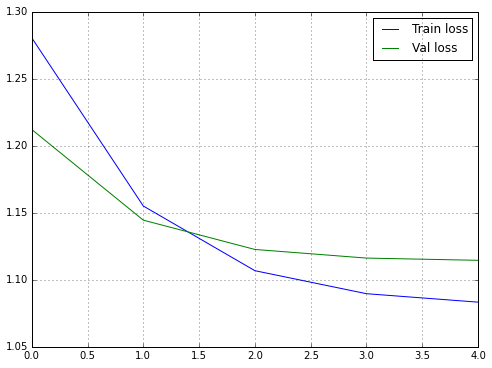

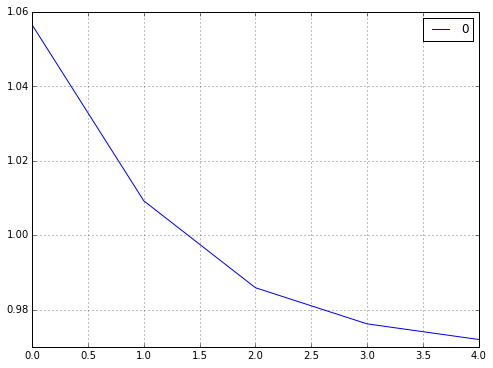

In [37]:
df_loss = pd.DataFrame({'Train loss' : mm.loss, 'Val loss' : mm.validation_loss})
df_loss.index = mm.epoch
df_loss.plot(figsize=(8, 6))

df_ratio = pd.DataFrame(mm.loss) / pd.DataFrame(mm.validation_loss)
df_ratio.index = mm.epoch
df_ratio.plot(figsize=(8, 6))